In [2]:
import matplotlib.pyplot as plt
import os
from os.path import join
import seaborn as sns
from PIL import Image
import cv2
import torch
import sys
sys.path.append('model_related')

from model import CNN1, CLASS_LABEL_DICT, transform
import train_model
from train_model import val_loader, test_loader, symbol_list
from card_processing import get_icons, display_card
from image_processing import contrast_enhancement, find_object_contours
from  model_metrics import get_predictions_and_labels, calculate_confusion_matrix, show_loss_curves

In [2]:
train_model.train()

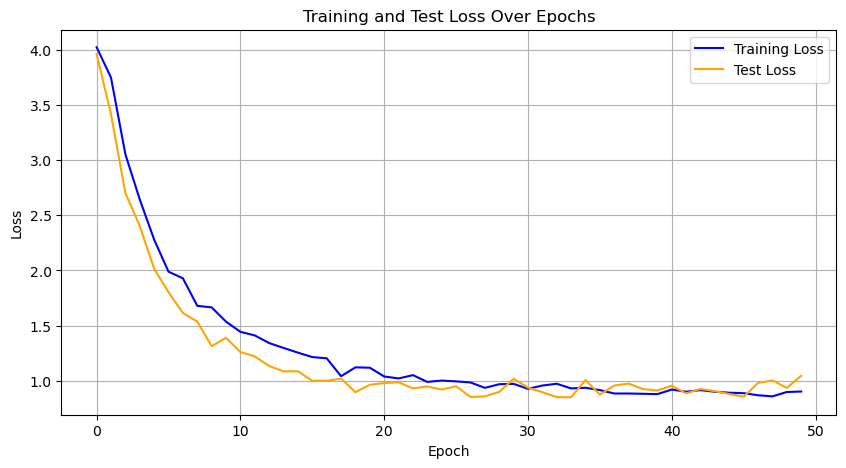

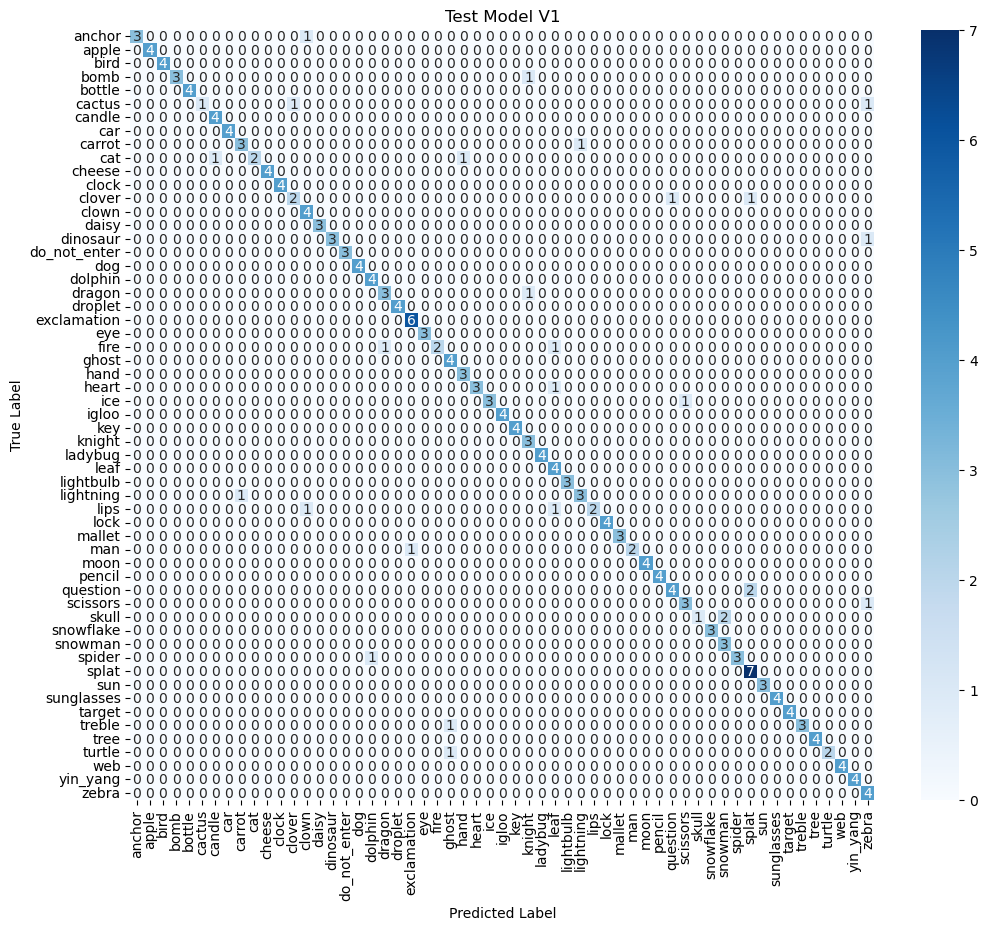

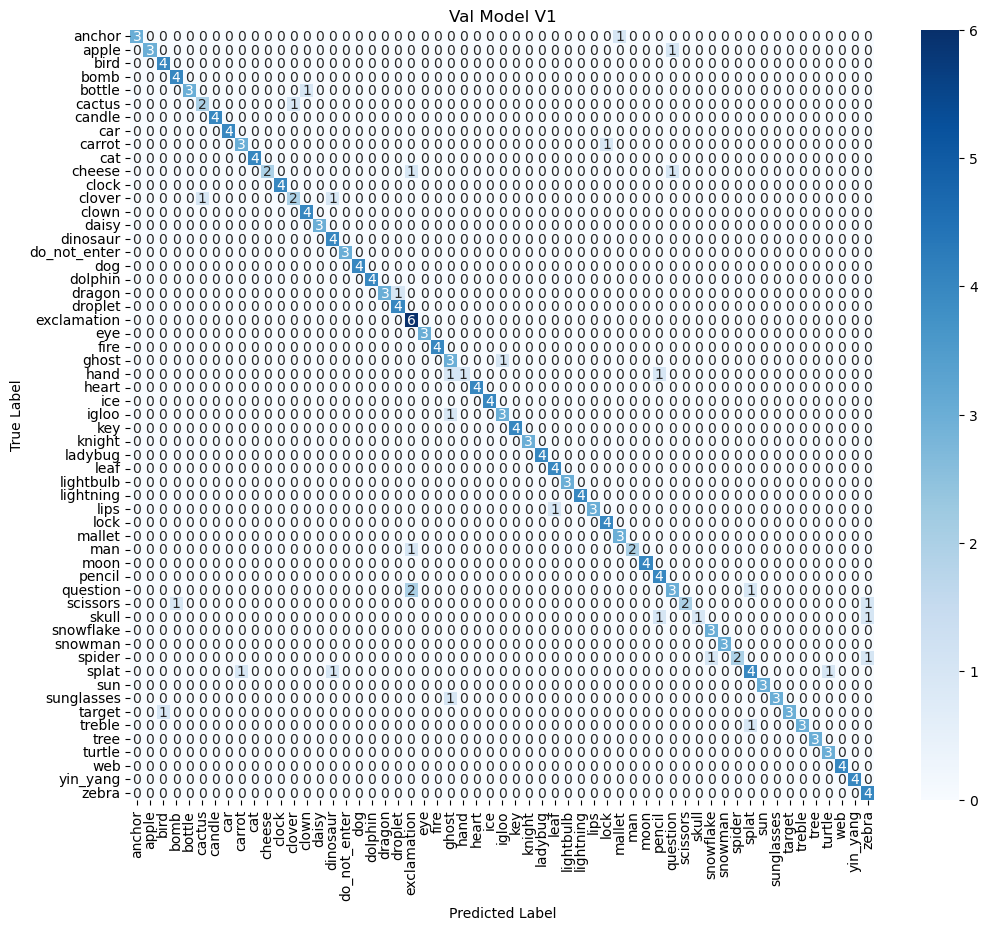

In [3]:
# Define and load the model
model = CNN1(num_classes=len(CLASS_LABEL_DICT))
model.load_state_dict(torch.load(join("model_related", "model_v4.pth"), weights_only=True))
model.eval()

# show training curves
show_loss_curves(join('model_related', 'train_loss.csv'), join('model_related', 'test_loss.csv'))

# show confusion matrix
output_neurons = len(CLASS_LABEL_DICT)
for i, model in enumerate([model]):
    predictions, gt_labels = get_predictions_and_labels(model, test_loader)
    val_pred, val_gt_labels = get_predictions_and_labels(model, val_loader)

    cards_cm = calculate_confusion_matrix(predictions, gt_labels, output_neurons)
    val_cm = calculate_confusion_matrix(val_pred, val_gt_labels, output_neurons)

    # Plotting the confusion matrix with ordered labels
    plt.figure(figsize=(12, 10))
    sns.heatmap(cards_cm, annot=True, fmt='d', cmap='Blues', vmin=0,
                xticklabels=symbol_list,
                yticklabels=symbol_list)
    plt.title(f'Test Model V{i+1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("\n")

    plt.figure(figsize=(12, 10))
    sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues', vmin=0,
                xticklabels=symbol_list,
                yticklabels=symbol_list)
    plt.title(f'Val Model V{i+1}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("\n")

In [4]:
# Load and preprocess the image
image_path = join("data", "test", "splat", "card02_01_contour_1.png")

image = Image.open(image_path).convert("RGB")
image_tensor = transform(image).unsqueeze(0)

# Predict the label
with torch.no_grad():
    outputs = model(image_tensor)
    _, predicted_label = torch.max(outputs, 1)


display(image)
print(f"Predicted Class: {CLASS_LABEL_DICT[predicted_label.item()]}")

Predicted Class: splat


There is a sun on both cards!


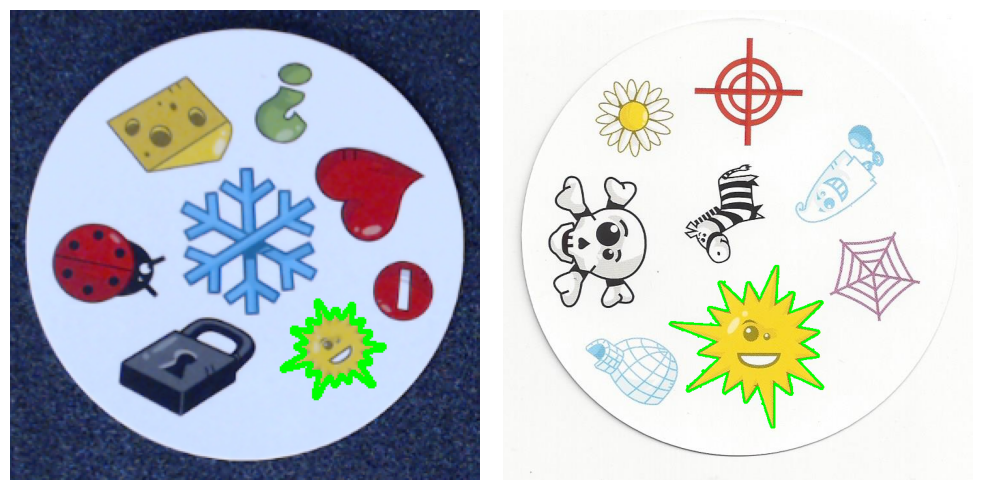

In [5]:
image1 = cv2.imread("card05_01.tif")
image2 = cv2.imread("card09_001.tif")
CLIP_LIMIT = 4.0
BINARY_THRESHOLD = 200
SYM_CARD_SIZE_RATIO = 1/20

card1, card1_contours = get_icons(image1, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
card2, card2_contours = get_icons(image2, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
matching_items = [item for item in card1 if item in card2]
match = matching_items[0]
card1_match_contour = card1_contours[card1.index(match)]
card2_match_contour = card2_contours[card2.index(match)]

print(f"There is a {match} on both cards!")
display_card(image1, image2, card1_match_contour, card2_match_contour)

There are 7 objects detected on card22_01.tif, with a minimum size of 1150.0


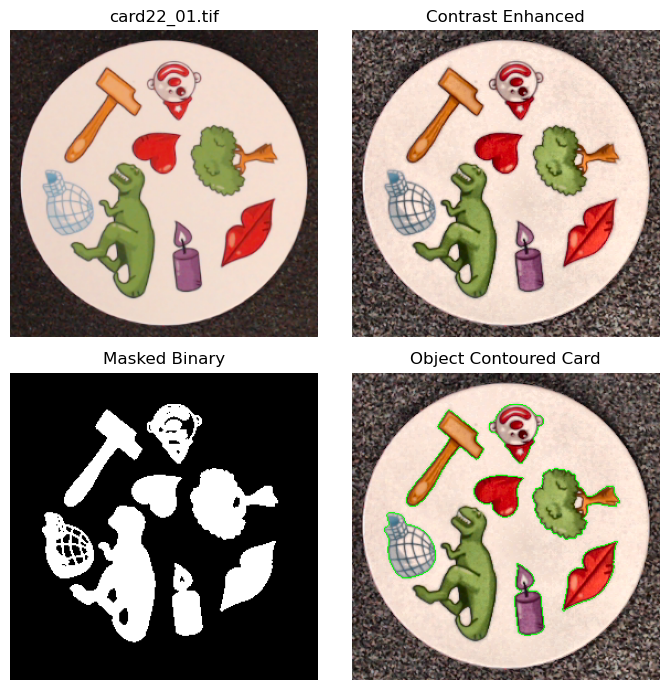

['candle', 'lips', 'igloo', 'heart', 'tree', 'mallet', 'clown']
There are 9 objects detected on card14_01.tif, with a minimum size of 229.5


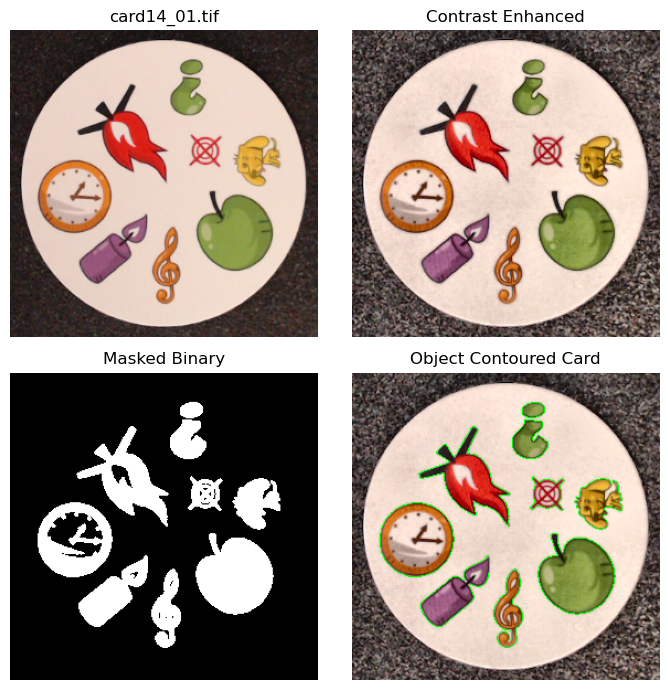

['treble', 'candle', 'apple', 'clock', 'cheese', 'target', 'fire', 'question', 'splat']
There are 9 objects detected on card45_01.tif, with a minimum size of 420.0


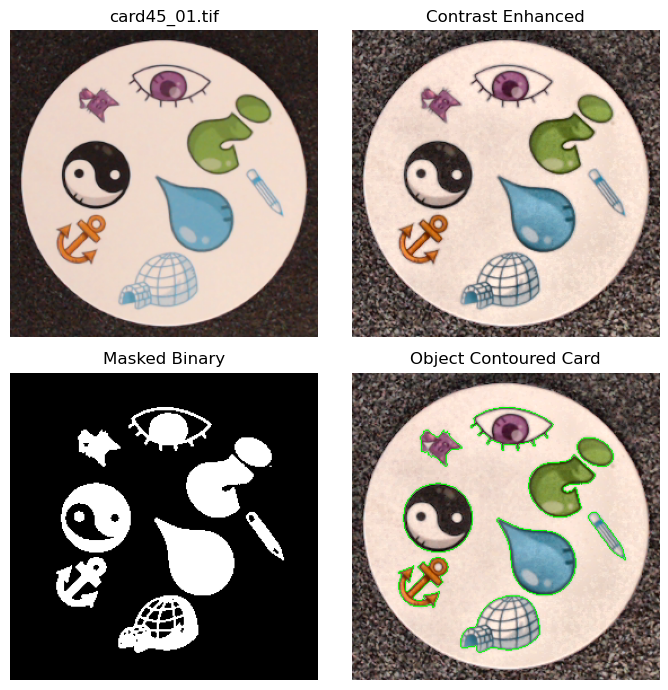

['igloo', 'anchor', 'droplet', 'pencil', 'yin_yang', 'question', 'question', 'cat', 'eye']
There are 9 objects detected on card08_01.tif, with a minimum size of 580.0


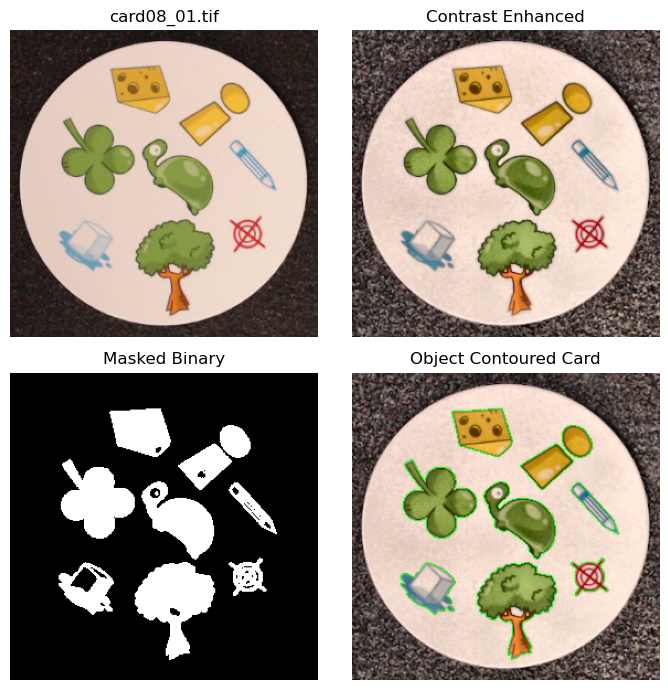

['tree', 'ice', 'bottle', 'pencil', 'turtle', 'clover', 'exclamation', 'exclamation', 'cheese']
There are 9 objects detected on card25_01.tif, with a minimum size of 456.0


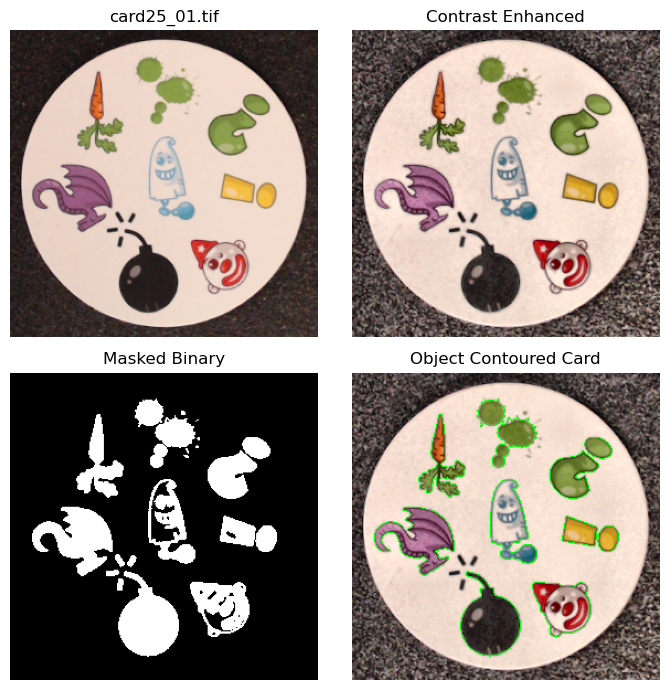

['clown', 'bomb', 'lightning', 'dragon', 'ghost', 'question', 'splat', 'carrot', 'splat']
There are 9 objects detected on card15_01.tif, with a minimum size of 488.5


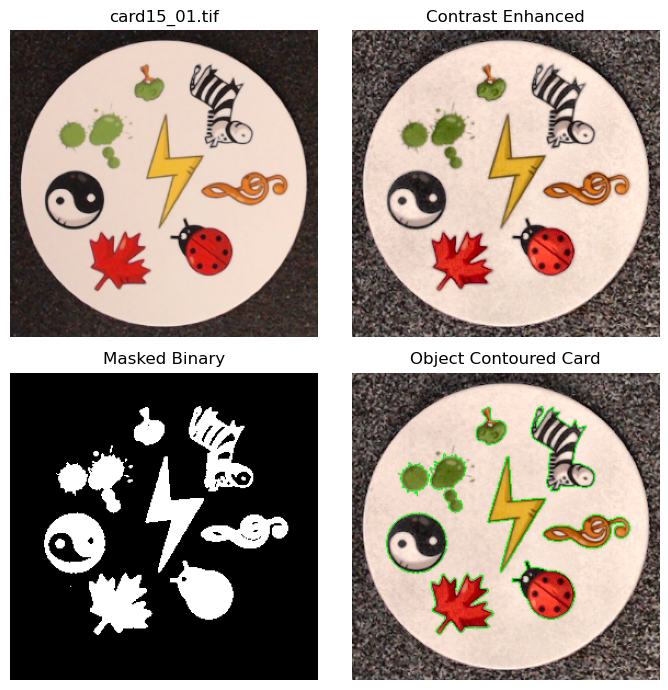

['leaf', 'ladybug', 'treble', 'yin_yang', 'splat', 'lightning', 'splat', 'splat', 'zebra']
There are 7 objects detected on card53_01.tif, with a minimum size of 1037.0


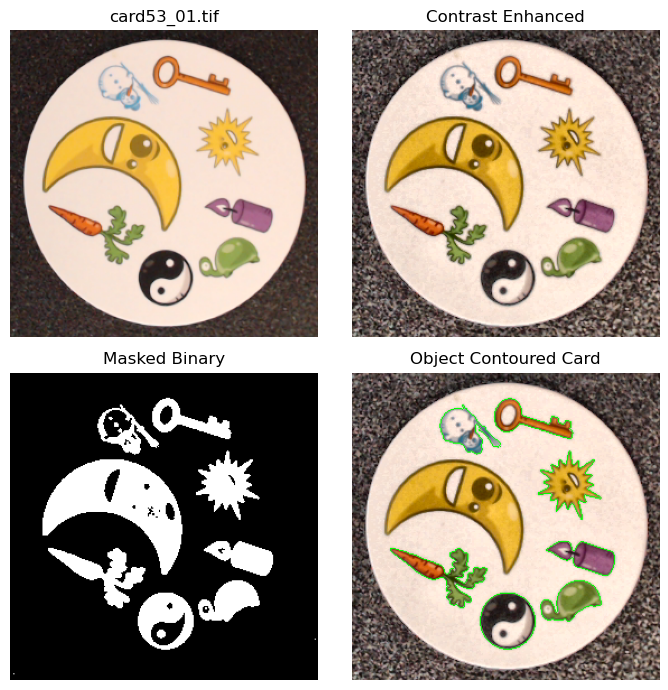

['yin_yang', 'turtle', 'carrot', 'candle', 'sun', 'snowman', 'key']
There are 9 objects detected on card03_01.tif, with a minimum size of 453.5


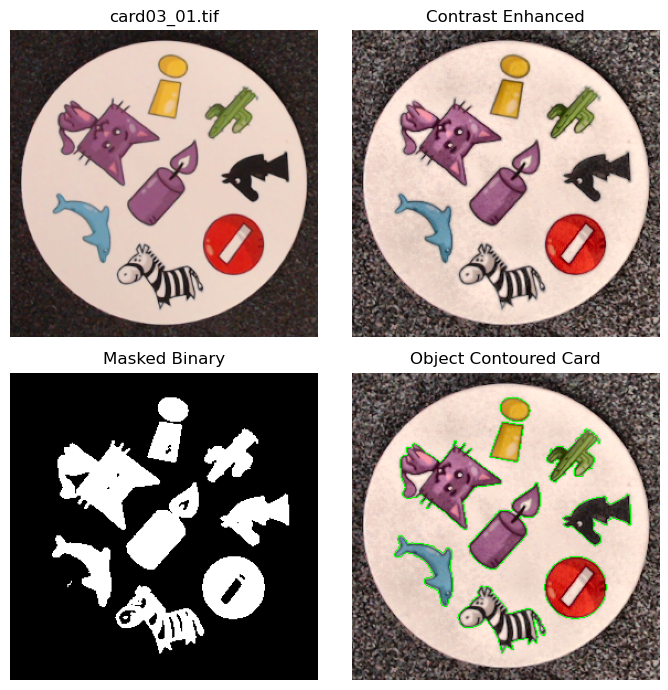

['zebra', 'do_not_enter', 'dolphin', 'knight', 'candle', 'cat', 'cactus', 'exclamation', 'exclamation']
There are 9 objects detected on card20_01.tif, with a minimum size of 504.0


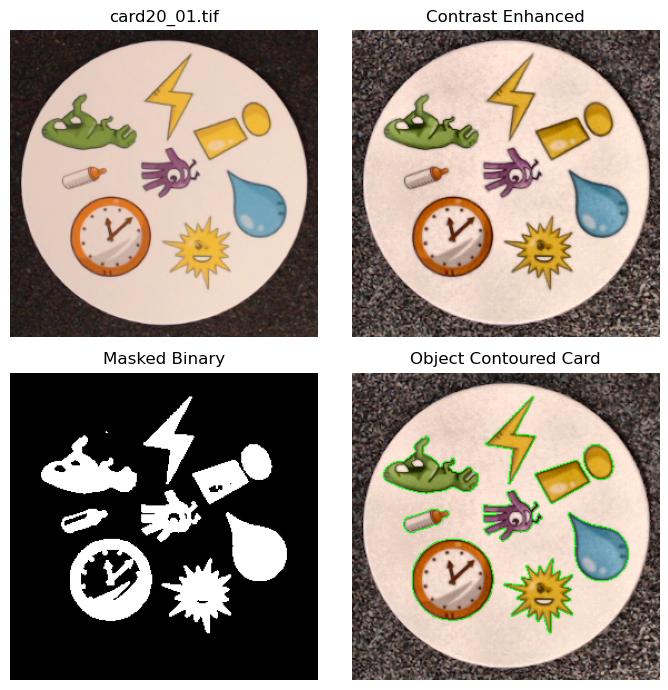

['sun', 'clock', 'droplet', 'bottle', 'hand', 'exclamation', 'exclamation', 'dinosaur', 'lightning']
There are 9 objects detected on card16_01.tif, with a minimum size of 410.0


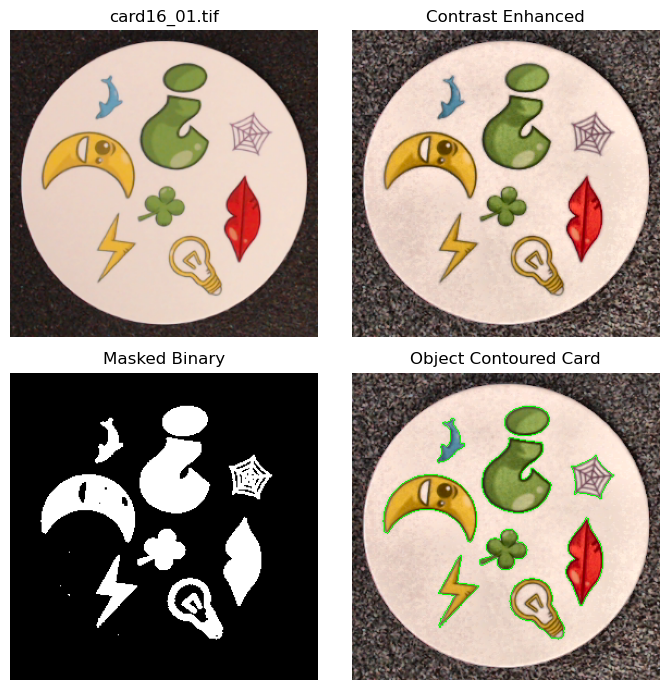

['lightbulb', 'lightning', 'clover', 'lips', 'moon', 'web', 'question', 'dolphin', 'question']
There are 9 objects detected on card30_01.tif, with a minimum size of 491.5


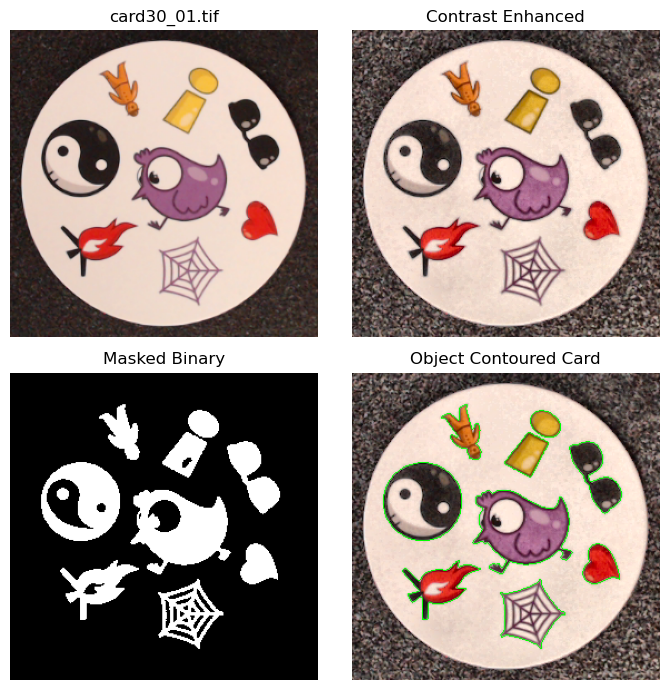

['web', 'fire', 'heart', 'bird', 'yin_yang', 'sunglasses', 'exclamation', 'exclamation', 'man']
I fucked up  11


In [6]:
counter = 0
for file in os.listdir("dobble_deck08_cards_55"):
  image = cv2.imread(join("dobble_deck08_cards_55", file))
  if image is None:
    print(file)
    continue

  ##### KEPT FOR VISUALIZATION #####
  # # enhance the contrast in the lightness color space
  enhanced_RGB = contrast_enhancement(image, CLIP_LIMIT)

  # # draw the smaller contours for visualization
  [card_mask, masked_binary, object_contours
    ] = find_object_contours(enhanced_RGB.copy(), SYM_CARD_SIZE_RATIO, BINARY_THRESHOLD)
  contoured_output_image = enhanced_RGB.copy()
  cv2.drawContours(contoured_output_image, object_contours, -1, (0, 255, 0), thickness=1)

  contour_areas = [cv2.contourArea(contour) for contour in object_contours]

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
  ##### #####

  icon_names, icon_contours = get_icons(image, CLIP_LIMIT, BINARY_THRESHOLD, SYM_CARD_SIZE_RATIO, model)
  if len(icon_names) != 8:
    counter += 1
    print(f"There are {len(object_contours)} objects detected on {file}, with a minimum size of {min(contour_areas)}")
    fig, axs = plt.subplots(2, 2, figsize=(7, 7))
    
    axs[0,0].imshow(image_rgb)
    axs[0,0].set_title(file)
    axs[0,0].axis("off")

    axs[0,1].imshow(enhanced_RGB, cmap="gray")
    axs[0,1].set_title(f'Contrast Enhanced')
    axs[0,1].axis("off")

    axs[1,0].imshow(masked_binary, cmap="gray")
    axs[1,0].set_title(f"Masked Binary")
    axs[1,0].axis("off")

    axs[1,1].imshow(contoured_output_image, cmap="gray")
    axs[1,1].set_title(f'Object Contoured Card')
    axs[1,1].axis("off")

    plt.tight_layout()
    plt.show()
    print(icon_names)
print("I fucked up ", counter)
